<a href="https://colab.research.google.com/github/ojimenezn/site-clustering/blob/main/adsorption-clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adsorption Site Clustering in Molecular Simulation

## Dependencies

In [ ]:
!pip install mpi4py
!git clone https://github.com/ojimenezn/site-clustering.git
!cd site-clustering/utils; python libsymf_builder.py
!pip install ase

In [ ]:
import sys
sys.path.insert(0, 'site-clustering')
import os
import shutil
from google.colab import drive
drive.mount('/drive')

import numpy as np
import pandas as pd
import torch
import sklearn as sk
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import umap
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from ase import Atoms
from ase.calculators.emt import EMT
from ase.constraints import FixAtoms
from ase.optimize import QuasiNewton
from ase.build import fcc100, fcc111, add_adsorbate
from ase.neighborlist import NeighborList, NewPrimitiveNeighborList
from ase.visualize import view
from ase.db import connect

from utils.fp_calculator import set_sym, calculate_fp, db_to_fp


if os.path.isdir(f'/drive/My Drive/classif-datasets'):
      shutil.rmtree(f'/drive/My Drive/classif-datasets')
if os.path.isdir(f'/drive/My Drive/classif-datasets/bfgs-logs'):
      shutil.rmtree(f'/drive/My Drive/classif-datasets/bfgs-logs')
if os.path.isdir(f'/drive/My Drive/classif-datasets/bfgs-trajs'):
      shutil.rmtree(f'/drive/My Drive/classif-datasets/bfgs-trajs')
if os.path.isdir(f'/drive/My Drive/classif-3g2-4g4'):
      shutil.rmtree(f'/drive/My Drive/classif-3g2-4g4')

if not os.path.isdir(f'/drive/My Drive/classif-datasets'):
      os.mkdir(f'/drive/My Drive/classif-datasets')
if not os.path.isdir(f'/drive/My Drive/classif-datasets/bfgs-logs'):
      os.mkdir(f'/drive/My Drive/classif-datasets/bfgs-logs')
if not os.path.isdir(f'/drive/My Drive/classif-datasets/bfgs-trajs'):
      os.mkdir(f'/drive/My Drive/classif-datasets/bfgs-trajs')
if not os.path.isdir(f'/drive/My Drive/classif-3g2-4g4'):
      os.mkdir(f'/drive/My Drive/classif-3g2-4g4')

Mounted at /drive


# Generating 3D Grid 

Each point in this grid will be an initial guess for the adsorbate.

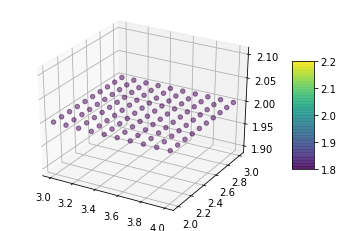

In [ ]:
X, Y, Z = np.mgrid[3:4:10j, 2:3:10j, 2:3:1j]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scat = ax.scatter(X, Y, Z, c=Z.flatten(), alpha=0.5)
fig.colorbar(scat, shrink=0.5, aspect=5)

# Generating Training Dataset

In [ ]:
iter = 1                                       
for i in range(len(X)):                           
   for j in range(len(X[i])):                  
       for k in range(len(X[i][j])):     
           # Initial guess for adsorbate
           h = Z[i][j][k]

           # Simple fcc111 surface, in which in principle there are only 2 adsorption sites (fcc, hcp)
           slab = fcc111('Pt', size=(3, 3, 2), vacuum=10.0)

           # Getting bare slab energy
           slab.calc = EMT()
           e_slab = slab.get_potential_energy()
           
           # Getting bare adsorbate energy
           atom = Atoms('Cu', positions=[(0., 0., 0.)])
           atom.calc = EMT()
           e_Cu = atom.get_potential_energy()

           # Adding adsorbate
           add_adsorbate(slab, 'Cu', h, position=(X[i][j][k], Y[i][j][k])) 
           
           # Rattling
           slab.rattle(stdev=0.001)

           # Writing initial config to db
           slab.set_calculator(EMT())
           initial_db = connect('/drive/My Drive/classif-datasets/initial-config.db')
           initial_db.write(slab)

           ### Write initial config to db with energy to get rid ASE error for db_to_fp ###
           slab.set_calculator(EMT())
           slab.get_potential_energy()
           emt_initial_db = connect('/drive/My Drive/classif-datasets/initial-config-emt.db')
           emt_initial_db.write(slab)

           # Set up BP symm func parameters
           elements = ['Pt','Cu']
           Gs = [2, 4]
           cutoff = 6.0
           g2_etas = [0.05, 4.0, 20.0, 80.0]
           g2_Rses = [0.0]
           g4_etas = [0.005]
           g4_zetas = [1.0, 4.0]
           g4_lambdas = [-1.0, 1.0]

           params_set = set_sym(elements, Gs, cutoff, g2_etas=g2_etas, g2_Rses=g2_Rses, 
                              g4_etas=g4_etas, g4_zetas=g4_zetas, g4_lambdas=g4_lambdas)
                              
           # Calculate fingerprint of initial (unrelaxed) configuration
           train_data = db_to_fp(emt_initial_db, params_set)

           # Relaxation
           constraint = FixAtoms(mask=[a.symbol != 'Cu' for a in slab])
           slab.set_constraint(constraint)
           dyn = QuasiNewton(slab, trajectory='PtCu.traj')
           dyn.run(fmax=0.05)  

           # Writing relaxed config to db 
           emt_relaxed_db = connect('/drive/My Drive/classif-datasets/relaxed-config-emt.db')
           emt_relaxed_db.write(slab)      

           # Calculate fingerprint of relaxed configuration 
           relaxed_data = db_to_fp(emt_relaxed_db, params_set)
           
           print(f'Relaxation {iter} done')

           iter+=1 

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 18:48:06        6.476970*       0.8137
BFGSLineSearch:    1[  1] 18:48:06        6.436060*       0.4829
BFGSLineSearch:    2[  3] 18:48:06        6.370507*       0.3425
BFGSLineSearch:    3[  5] 18:48:06        6.338428*       0.2535
BFGSLineSearch:    4[  6] 18:48:06        6.331644*       0.2875
BFGSLineSearch:    5[  7] 18:48:06        6.327887*       0.0751
BFGSLineSearch:    6[  8] 18:48:06        6.327442*       0.0040
Relaxation 1 done
                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  0] 18:48:07        6.510123*       0.9628
BFGSLineSearch:    1[  1] 18:48:07        6.462014*       0.4785
BFGSLineSearch:    2[  3] 18:48:07        6.405425*       0.3295
BFGSLineSearch:    3[  5] 18:48:07        6.392061*       0.3097
BFGSLineSearch:    4[  7] 18:48:07     

# Dataset Preprocessing

In [ ]:
train_fp = train_data['b_fp']

# Preprocessing
fp_max = torch.max(train_fp.view(-1, train_fp.size(2)), dim=0)
fp_min = torch.min(train_fp.view(-1, train_fp.size(2)), dim=0)
train_nrg = train_data['b_e']
nrg_max = torch.max(train_nrg)
nrg_min = torch.min(train_nrg)
scale = {'fp_max': fp_max[0], 'fp_min': fp_min[0], 'nrg_max': nrg_max, 'nrg_min': nrg_min}
train_fp = (train_data['b_fp'] - scale['fp_min']) / (scale['fp_max'] - scale['fp_min'] + 1e-10)

N_atoms = train_data['N_atoms']
b_fp = train_fp
b_f = train_data['b_f']
b_e_mask = train_data['b_e_mask']
b_e = train_data['b_e']
b_dfpdX = train_data['b_dfpdX']

b_fp_relaxed = relaxed_data['b_fp']
b_f_relaxed = relaxed_data['b_f']
b_e_relaxed = relaxed_data['b_e']
b_dfpdX_relaxed = relaxed_data['b_dfpdX']

"""
# fp of initial guess
b_fp_adsorbate = train_fp
df = b_fp_adsorbate[0,18]
df = df.numpy()
df = pd.DataFrame(df)
df = pd.DataFrame(df.values.reshape(1, -1))

for i in range(1, b_fp_adsorbate.size(0)):
  df_new = b_fp_adsorbate[i,18]
  df_new = df_new.numpy()
  df_new = pd.DataFrame(df_new)
  df_new = pd.DataFrame(df_new.values.reshape(1, -1))
  df = df.append(df_new, ignore_index=True)
"""

# For umap we need data as a pandas dataframe
df = b_fp[0]
df = df.numpy()
df = pd.DataFrame(df)
df = pd.DataFrame(df.values.reshape(1, -1))

for i in range(1, b_fp.size(0)):
  df_new = b_fp[i]
  df_new = df_new.numpy()
  df_new = pd.DataFrame(df_new)
  df_new = pd.DataFrame(df_new.values.reshape(1, -1))
  df = df.append(df_new, ignore_index=True)


# Adding labels to pandas df (relaxed adsorption energies)
ads_energy = b_e_relaxed.tolist()
ads_energy = [(e_slab + e_Cu - x) for x in ads_energy]
ads_energy = [round(num, 3) for num in ads_energy]
df['energy'] = ads_energy

# NeighborList to ensure labels are correct for fcc (7) and hcp (8)
nl_total = []
for row in emt_relaxed_db.select():
  atoms = row.toatoms()
  nl= NeighborList([2.2]*len(atoms),
                  skin=0.0, bothways=True,
                  self_interaction=True,
                  primitive=NewPrimitiveNeighborList)
  nl.update(atoms)
  indices, _ =nl.get_neighbors(18)
  nl_total.append(float(len(indices)))

df['neighbors'] = nl_total

conditions  = [
    ((df['energy'] == 2.982) & (df['neighbors'] == 7)),
    ((df['energy'] == 2.983) & (df['neighbors'] == 7)),
    ((df['energy'] == 2.984) & (df['neighbors'] == 7)),
    ((df['energy'] == 2.985) & (df['neighbors'] == 7)),
    ((df['energy'] == 2.982) & (df['neighbors'] == 8)),
    ((df['energy'] == 2.983) & (df['neighbors'] == 8)),
    ((df['energy'] == 2.984) & (df['neighbors'] == 8)),
    ((df['energy'] == 2.985) & (df['neighbors'] == 8)),
    (df['energy'] == 2.404),
    (df['energy'] == 2.405),
    (df['energy'] == 2.406),
    (df['energy'] == 2.852),
    (df['energy'] == 2.853),
    (df['energy'] == 2.854),
    (df['energy'] == 2.855)
]

sites = ['fcc','fcc','fcc','fcc','hcp','hcp','hcp','hcp',
         'ontop','ontop','ontop','bridge','bridge','bridge','bridge']
df['site'] = np.select(conditions, sites)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,energy,neighbors,site
0,0.999758,0.99926,0.603872,0.00003,0.052179,0.004046,1.285264e-07,1.743049e-24,0.999048,0.999581,0.998359,0.999882,0.006972,0.064501,0.000383,0.131431,0.0,0.0,0.0,0.0,0.999553,0.999079,0.603613,0.000029,0.246002,0.050894,0.000086,3.475335e-15,0.99892,0.999221,0.998563,0.999406,0.070575,0.442322,0.011840,0.794471,0.0,0.0,0.0,0.0,...,9.730810e-07,0.267589,0.037252,0.000017,1.059261e-17,0.995969,0.997331,0.994408,0.998166,0.032397,0.240241,0.002999,0.450107,0.0,0.0,0.0,0.0,0.024886,0.000049,0.053582,0.033889,0.0,0.0,0.0,0.0,0.019084,0.003849,0.016255,0.007675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.984,8.0,hcp
1,0.999758,0.99926,0.603872,0.00003,0.050889,0.003902,1.184984e-07,1.357174e-24,0.999048,0.999581,0.998359,0.999882,0.006733,0.062606,0.000363,0.127878,0.0,0.0,0.0,0.0,0.999553,0.999079,0.603613,0.000029,0.242813,0.049679,0.000080,2.738489e-15,0.99892,0.999221,0.998563,0.999406,0.068900,0.434918,0.011252,0.782689,0.0,0.0,0.0,0.0,...,9.730810e-07,0.267179,0.039387,0.000025,4.479611e-17,0.995969,0.997331,0.994408,0.998166,0.033697,0.243260,0.003427,0.451927,0.0,0.0,0.0,0.0,0.023637,0.000035,0.081284,0.040716,0.0,0.0,0.0,0.0,0.018526,0.003335,0.015842,0.006704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.983,8.0,hcp
2,0.999758,0.99926,0.603872,0.00003,0.049309,0.003729,1.070710e-07,9.938666e-25,0.999048,0.999581,0.998359,0.999882,0.006442,0.060300,0.000339,0.123495,0.0,0.0,0.0,0.0,0.999553,0.999079,0.603613,0.000029,0.238882,0.048203,0.000074,2.036058e-15,0.99892,0.999221,0.998563,0.999406,0.066876,0.425840,0.010557,0.768155,0.0,0.0,0.0,0.0,...,9.730810e-07,0.268416,0.042485,0.000036,1.782092e-16,0.995969,0.997331,0.994408,0.998166,0.035733,0.249058,0.004039,0.457671,0.0,0.0,0.0,0.0,0.022332,0.000018,0.102562,0.046101,0.0,0.0,0.0,0.0,0.018088,0.002717,0.015546,0.005513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.983,8.0,hcp
3,0.999758,0.99926,0.603872,0.00003,0.047456,0.003530,9.478769e-08,6.843360e-25,0.999048,0.999581,0.998359,0.999882,0.006106,0.057619,0.000313,0.118339,0.0,0.0,0.0,0.0,0.999553,0.999079,0.603613,0.000029,0.234233,0.046489,0.000066,1.428257e-15,0.99892,0.999221,0.998563,0.999406,0.064545,0.415181,0.009781,0.750960,0.0,0.0,0.0,0.0,...,9.730810e-07,0.271280,0.046458,0.000053,6.672130e-16,0.995969,0.997331,0.994408,0.998166,0.038464,0.257451,0.004833,0.467120,0.0,0.0,0.0,0.0,0.021166,0.000005,0.114511,0.049197,0.0,0.0,0.0,0.0,0.017845,0.002118,0.015407,0.004329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.984,8.0,hcp
4,0.999758,0.99926,0.603872,0.00003,0.045350,0.003309,8.218711e-08,4.429045e-25,0.999048,0.999581,0.998359,0.999882,0.005733,0.054602,0.000284,0.112481,0.0,0.0,0.0,0.0,0.999553,0.999079,0.603613,0.000029,0.228893,0.044563,0.000059,9.452063e-16,0.99892,0.999221,0.998563,0.999406,0.061949,0.403039,0.008949,0.731214,0.0,0.0,0.0,0.0,...,9.730810e-07,0.275744,0.051217,0.000077,2.352015e-15,0.995969,0.997331,0.994408,0.998166,0.041829,0.268210,0.005795,0.479996,0.0,0.0,0.0,0.0,0.020196,0.000000,0.115539,0.049492,0.0,0.0,0.0,0.0,0.017831,0.001582,0.015445,0.003225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.983,7.0,fcc


# U-Map (Clustering)

In [ ]:
umap_df = df.drop(['energy', 'neighbors', 'site'], axis=1)

# Instantiating UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(umap_df)
embedding.shape

(100, 2)

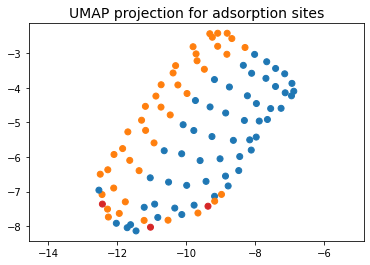

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in df.site.map({"fcc":0, "hcp":1, "ontop":2, "bridge":3})])
    # fcc (blue), hcp (orange), ontop (green), bridge (red)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection for adsorption sites', fontsize=14)
plt.savefig('/drive/My Drive/umap.png', dpi=500)

# T-SNE

In [ ]:
tsne_df = df.drop(['energy', 'neighbors', 'site'], axis=1)
embedding_tsne = TSNE(n_components=2).fit_transform(tsne_df)
embedding_tsne.shape

(100, 2)

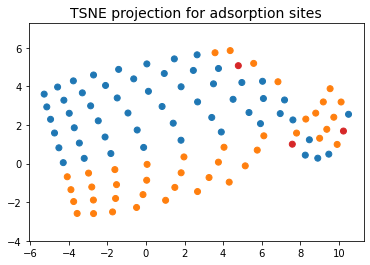

In [ ]:
plt.scatter(
    embedding_tsne[:, 0],
    embedding_tsne[:, 1],
    c=[sns.color_palette()[x] for x in df.site.map({"fcc":0, "hcp":1, "ontop":2, "bridge":3})])
    # fcc (blue), hcp (orange), ontop (green), bridge (red)
plt.gca().set_aspect('equal', 'datalim')
plt.title('TSNE projection for adsorption sites', fontsize=14)
plt.savefig('/drive/My Drive/tsne.png', dpi=500)